## Direct Marketing Effectiveness: A Logistic Regression Approach

**This example demonstrates the implementation of logistic regression to predict whether a client will subscribe to a term deposit based on the
outcomes of direct marketing campaigns (via phone calls).**

**Logistic regression is a classification algorithm.<br> It predicts the likelihood of a categorical outcome (like binary decisions: yes/no, 0/1).<br> Specifically, it estimates the probability 𝑃(𝑌=1) given the input variables 𝑋.** <br>
**For instance, in our banking example, it calculates the probability that a client will subscribe to a term deposit (1) or not (0)**

**Assumptions in Logistic Regression**<br>
**No Multicollinearity**: The independent variables (predictors) should not be highly correlated with each other.<br>
**Linear Relationship to Log Odds**: The independent variables should have a linear relationship with the log odds of the outcome.<br>
**Large Sample Size**: Logistic regression works best with large datasets to ensure reliable and stable predictions.

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
data = pd.read_csv(r"C:\Users\Dell\Downloads\banking.csv",header=0)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [4]:
# Dropping the null values
data = data.dropna() 

In [5]:
data.shape

(41188, 21)

In [6]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

**Understanding the Data**

1. **age** (numeric)<br>
2. **job**: type of job (categorical: “admin”, “blue-collar”, “entrepreneur”, “housemaid”, “management”, “retired”, “self-employed”, “services”, “student”, “technician”, “unemployed”, “unknown”)<br>
3. **marital**: marital status (categorical: “divorced”, “married”, “single”, “unknown”)<br>
4. **education** (categorical: “basic.4y”, “basic.6y”, “basic.9y”, “high.school”, “illiterate”, “professional.course”, “university.degree”, “unknown”)<br>
5. **default**: has credit in default? (categorical: “no”, “yes”, “unknown”)<br>
6. **housing**: has housing loan? (categorical: “no”, “yes”, “unknown”)<br>
7. **loan**: has personal loan? (categorical: “no”, “yes”, “unknown”)<br>
8. **contact**: contact communication type (categorical: “cellular”, “telephone”)<br>
9. **month**: last contact month of year (categorical: “jan”, “feb”, “mar”, …, “nov”, “dec”)<br>
10. **day_of_week**: last contact day of the week (categorical: “mon”, “tue”, “wed”, “thu”, “fri”)<br>
11. **duration**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model<br>
12. **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13. **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
14. **previous**: number of contacts performed before this campaign and for this client (numeric)<br>
15. **poutcome**: outcome of the previous marketing campaign (categorical: “failure”, “nonexistent”, “success”)<br>
16. **emp.var.rate**: employment variation rate — (numeric)<br>
17. **cons.price.idx**: consumer price index — (numeric)<br>
18. **cons.conf.idx**: consumer confidence index — (numeric)<br>
19. **euribor3m**: euribor 3 month rate — (numeric)<br>
20. **nr.employed**: number of employees — (numeric)<br>


**Target Variable**<br>
y — has the client subscribed a term deposit? (binary: “1”, means “Yes”, “0” means “No”)

**Bucketing** is the process of grouping multiple categories into fewer, broader ones to simplify data for modeling.<br> **For example**, in the education column, instead of handling categories like "basic.4y," "basic.6y," "university.degree," etc., you could combine them into buckets like "basic," "higher education," and "unknown." <br>This helps reduce complexity and improves model performance.<br>

**Bucketing : Education**<br>
Education has many categories. We are going to reduce it for better modeling.

In [7]:
data['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [8]:
## Grouping basic - 4,6 and 9 years into basic

data['education']=np.where(data['education']=='basic.9y','Basic',data['education'])
data['education']=np.where(data['education']=='basic.6y','Basic',data['education'])
data['education']=np.where(data['education']=='basic.4y','Basic',data['education'])

In [9]:
## Checking the education field again

data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

In [10]:
# Understanding the Target variable first

data['y'].value_counts()

y
0    36548
1     4640
Name: count, dtype: int64

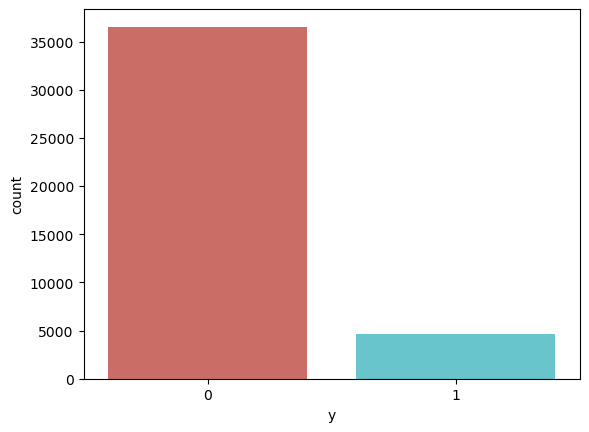

In [11]:
# Visualizing

# Countplot is a type of bar plot in Seaborn that displays the frequency of categorical variables.
sns.countplot(x='y', data=data, hue='y', palette='hls', legend=False)
plt.show()
# plt.savefig('count_plot')

In [12]:
# By looking at th graph, we can understand that, we have 36548 cases of 'no success', and '4640' cases of success.

In [13]:
print(data.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

In [17]:
# Summarization

data.groupby('y').mean(numeric_only=True) 
# Use this numeric_only=True or else the noteboon file will crash coz it will take string values too into account.

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


**Observations from above summary**
- Converted individuals tend to be older on average than those who didn't convert.
- People who converted spent more time on calls compared to non-converters.
- Fewer campaigns were targeted at people who converted, as opposed to those who didn’t.

**Visualizations**

**1. Purchase by job type**

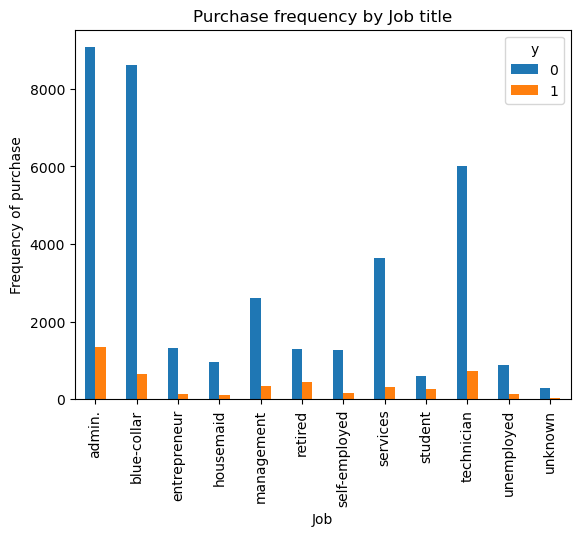

In [25]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase frequency by Job title')
plt.xlabel('Job')
plt.ylabel('Frequency of purchase')
plt.savefig('purchase_by_job')

**Jobs seem to be an important predictor variable.**

**2. Purchase by marital status**

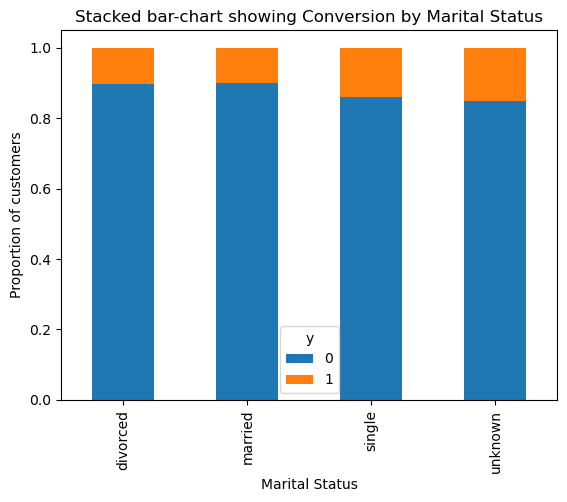

In [26]:
%matplotlib inline
table = pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked bar-chart showing Conversion by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of customers')
plt.savefig('purchase_by_ms')

**No variation within each of the classes, and hence doesnt seem to be an important predictor variable.**

**3. Purchase by education**

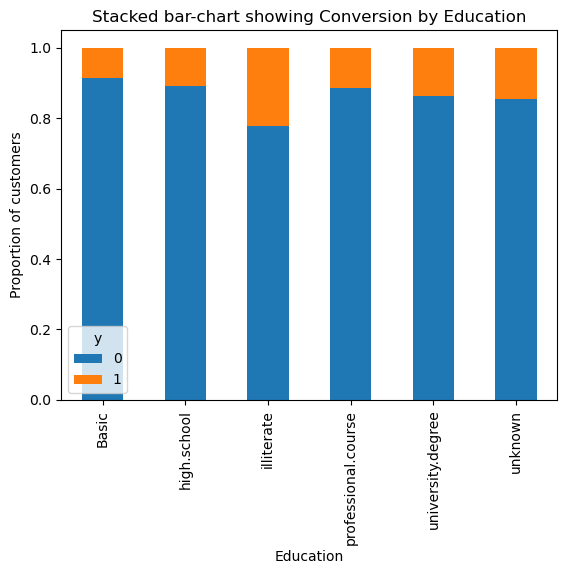

In [27]:
%matplotlib inline
table = pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked bar-chart showing Conversion by Education')
plt.xlabel('Education')
plt.ylabel('Proportion of customers')
plt.savefig('purchase_by_edu')

**The level of education appears to be a significant factor in predicting success—those with lower literacy levels seem more receptive to these marketing calls.**

**4. Purchase quantity by Month**

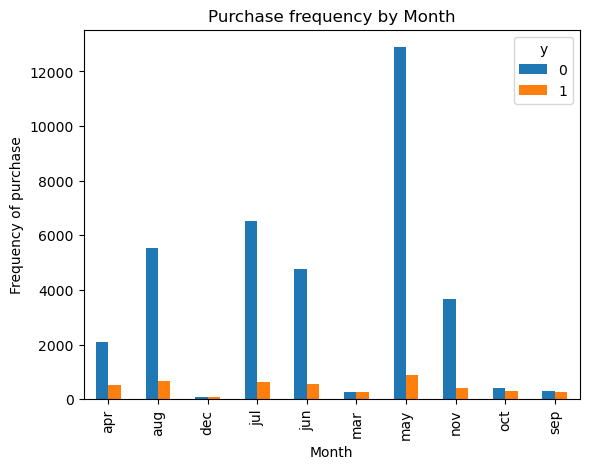

In [28]:
%matplotlib inline
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase frequency by Month')
plt.xlabel('Month')
plt.ylabel('Frequency of purchase')
plt.savefig('purchase_by_mnt')

**The number of conversions appears to follow a seasonal pattern, with certain months playing a significant role in influencing the outcomes.**

**5. Understanding the Day of Week effect**

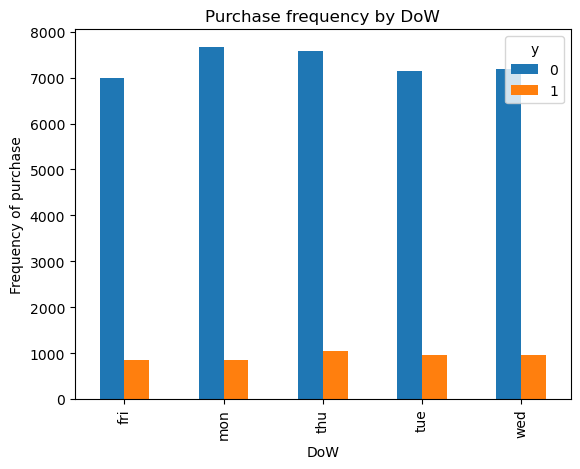

In [29]:
%matplotlib inline
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase frequency by DoW')
plt.xlabel('DoW')
plt.ylabel('Frequency of purchase')
plt.savefig('purchase_by_dow')

**The Day of the Week appears to carry limited information and may not serve as a strong predictor variable.**

**6. Purchase frequency by Previous outcomes**

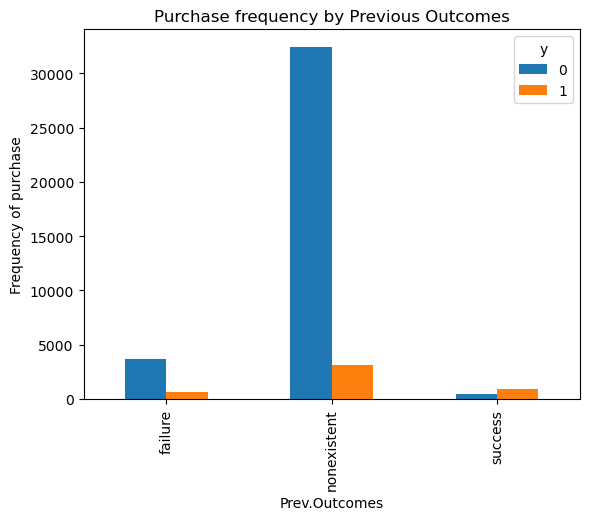

In [30]:
%matplotlib inline
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase frequency by Previous Outcomes')
plt.xlabel('Prev.Outcomes')
plt.ylabel('Frequency of purchase')
plt.savefig('purchase_by_pout')

**New target customers appear to have higher conversion rates. Additionally, previous outcomes emerge as a significant factor for making accurate predictions.**

### Creating Dummy Variables

**Many fields are categorical, so we will encode them as dummy variables. These dummy variables will represent the categories with binary values.**

In [31]:
# Defining  the list of categorical columns that need to be encoded into dummy variables
categorical_variable_cols = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

# Looping through each categorical column and create dummy variables
for var in categorical_variable_cols:
    categ_list = 'var_' + var  # Creating a variable name dynamically for dummy columns
    categ_list = pd.get_dummies(data[var], prefix=var)  # Generating dummy variables with a prefix
    data1 = data.join(categ_list)  # Appending the dummy variables to the original dataset
    data = data1  # Updating the dataset with the appended dummy variables

## Identifying the columns to keep (excluding the original categorical columns)
data_vars = data.columns.values.tolist()  # Get the list of all column names
to_keep = [i for i in data_vars if i not in categorical_variable_cols]  # Filter out the categorical columns


**Final columns to keep**

In [33]:
data_final = data[to_keep]
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

**Setting the X & Y values**

In [35]:
data_final_vars = data_final.columns.values.tolist()
y=['y']
X = [i for i in data_final_vars if i not in y]

### Feature Selection

RFE (Recursive Feature Elimination) is a feature selection method that repeatedly removes the least important features from a dataset, based on their contribution to a model's performance (e.g., coefficients or feature importance). <br>This process continues until the desired number of features remains, ensuring the most relevant features are selected. It simplifies the dataset while improving prediction accuracy.



In [38]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression estimator
logreg = LogisticRegression()

# Initialize RFE with estimator and number of features to select
rfe = RFE(estimator=logreg, n_features_to_select=18)

# Fit RFE on the dataset
rfe = rfe.fit(data_final[X], data_final[y])

# Extract the selected features and their ranks
Selected_Features_Support = list(rfe.support_)
Selected_Features_Rank = list(rfe.ranking_)

# Print the results
print(Selected_Features_Support)
print(Selected_Features_Rank)

C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

[False, False, False, False, True, False, False, False, True, False, False, True, False, False, False, True, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, True, True, True, False, False, True, True, True, True, False, False, True, False, False, False, True, False, True]
[33, 31, 9, 38, 1, 10, 22, 15, 1, 30, 29, 1, 4, 37, 39, 1, 40, 1, 1, 21, 26, 42, 32, 23, 12, 43, 17, 19, 41, 27, 5, 2, 1, 20, 44, 36, 34, 11, 13, 35, 25, 1, 18, 1, 1, 1, 6, 14, 1, 1, 1, 1, 24, 28, 1, 8, 7, 3, 1, 16, 1]


**Based on the RFE results**<br> We will focus on the following selected features: “previous,” “euribor3m,” “job_blue-collar,” “job_retired,” “job_services,” “job_student,” “default_no,” “month_aug,” “month_dec,” “month_jul,” “month_nov,” “month_oct,” “month_sep,” “day_of_week_fri,” “day_of_week_wed,” “poutcome_failure,” “poutcome_nonexistent,” and “poutcome_success.”

In [39]:
columns_final = ["previous", "euribor3m", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", 
      "month_aug", "month_dec", "month_jul", "month_nov", "month_oct", "month_sep", "day_of_week_fri", "day_of_week_wed", 
      "poutcome_failure", "poutcome_nonexistent", "poutcome_success"] 

X = data_final[columns_final]
y = data_final['y']

### Model Implementation

**Executing the final model using the chosen features ensures that the analysis is optimized with only the most significant predictors.**

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state=0)

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression()

In [45]:
y_pred = logreg.predict(X_test)

#Calculating the accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.90


### Cross Validation

To prevent overfitting, we will employ 10-fold cross-validation (CV) to train our logistic regression model. <br>This approach helps ensure the model generalizes well to unseen data.

In [47]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

kfold = model_selection.KFold(n_splits = 10)

modelCV = LogisticRegression()

scoring = 'accuracy'

results = model_selection.cross_val_score(modelCV, X_train,y_train, cv = kfold, scoring = scoring)

print("10-fold cross-validation average accuracy : %.3f" % (results.mean()))

10-fold cross-validation average accuracy : 0.896


The average accuracy from cross-validation is closely aligned with the test set accuracy, indicating that our model generalizes effectively.

### Creating the truth table (Confusion Matrix)


In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[10872   109]
 [ 1123   253]]


**Calculating Precission, Recall & F1 score**

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10981
           1       0.70      0.18      0.29      1376

    accuracy                           0.90     12357
   macro avg       0.80      0.59      0.62     12357
weighted avg       0.88      0.90      0.87     12357



The model demonstrates strong overall performance metrics, including high precision, recall, and F-score, indicating its effectiveness in making accurate predictions.

